In [0]:
!git clone https://github.com/dipsankarb/recolab-data.git

Cloning into 'recolab-data'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 0), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [0]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import style

path = '/content/recolab-data/latent/train.txt'
train_data = []
test_data = []
with open(path) as f:
    data = f.read().split('\n')
    for line in data[:-1]:
        l = line.split('\t')

        train_data.append([int(x) for x in l])

train_data = np.array(train_data)
print(train_data.shape)

path = '/content/recolab-data/latent/test.txt'
with open(path) as f:
    data = f.read().split('\n')
    for line in data[:-1]:
        l = line.split('\t')

        test_data.append([int(x) for x in l])

test_data = np.array(test_data)
print(test_data.shape)

(90000, 3)
(10000, 3)


In [0]:
class Latent_Factor():
    def __init__(self,R,K,alpha,beta,iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        print("Latent factor : ",self.K)
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process
    
    def mse(self):
         xs, ys = self.R.nonzero()
         predicted = self.full_matrix()
         error = 0
         for x, y in zip(xs, ys):
             error += pow(self.R[x, y] - predicted[x, y], 2)
         return np.sqrt(error)

    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = 2*(r - prediction)

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - 2*self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - 2*self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        prediction = self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self): 
        return self.P.dot(self.Q.T)

1682 943
[[5. 4. 0. ... 5. 0. 0.]
 [3. 0. 0. ... 0. 0. 5.]
 [4. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]]
Latent factor :  10
Iteration: 10 ; error = 235.0649
Iteration: 20 ; error = 223.0502
Iteration: 30 ; error = 220.0762
Iteration: 40 ; error = 220.2232
Test Error :  11195.196377418251


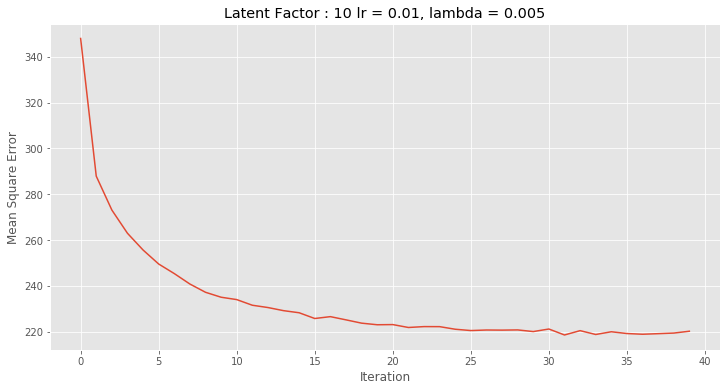

Latent factor :  20
Iteration: 10 ; error = 210.4379
Iteration: 20 ; error = 184.4966
Iteration: 30 ; error = 176.2999
Iteration: 40 ; error = 172.6796
Test Error :  12562.917255600338


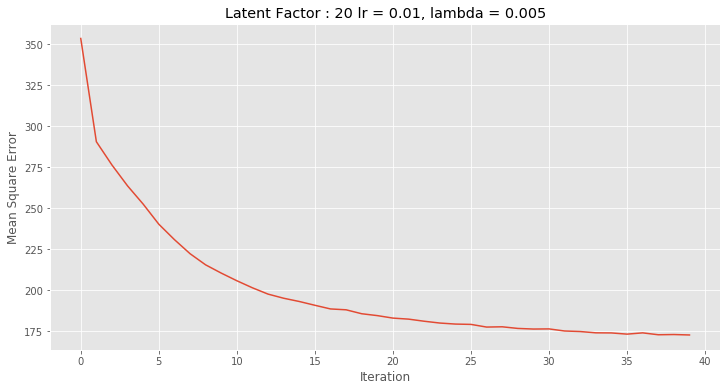

Latent factor :  40
Iteration: 10 ; error = 186.2209
Iteration: 20 ; error = 132.5137
Iteration: 30 ; error = 116.5832
Iteration: 40 ; error = 108.5488
Test Error :  13410.581974187642


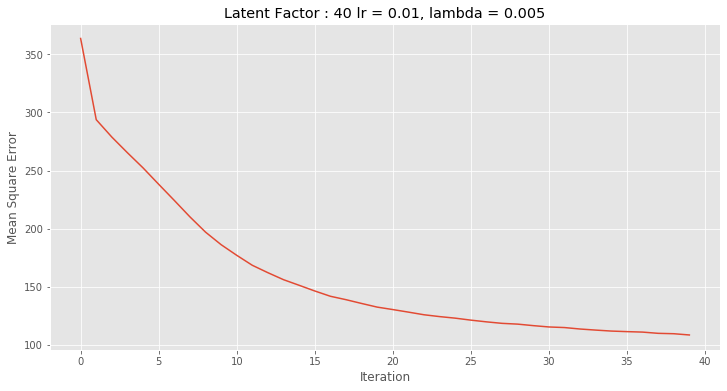

Latent factor :  80
Iteration: 10 ; error = 178.7498
Iteration: 20 ; error = 84.1906
Iteration: 30 ; error = 55.9874
Iteration: 40 ; error = 45.0934
Test Error :  11741.29617653721


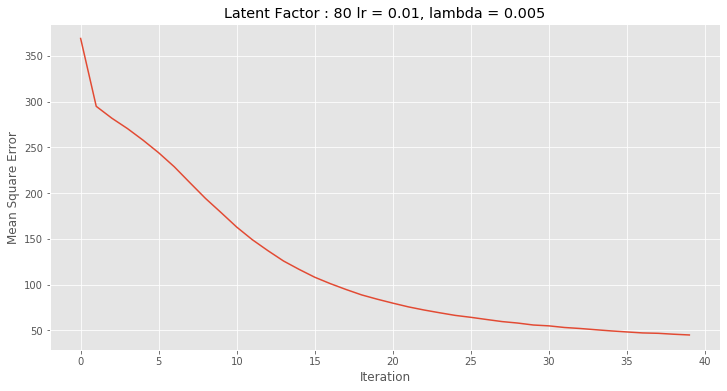

Latent factor :  100
Iteration: 10 ; error = 180.1565
Iteration: 20 ; error = 74.6754
Iteration: 30 ; error = 43.7768
Iteration: 40 ; error = 32.3101
Test Error :  10709.47170573635


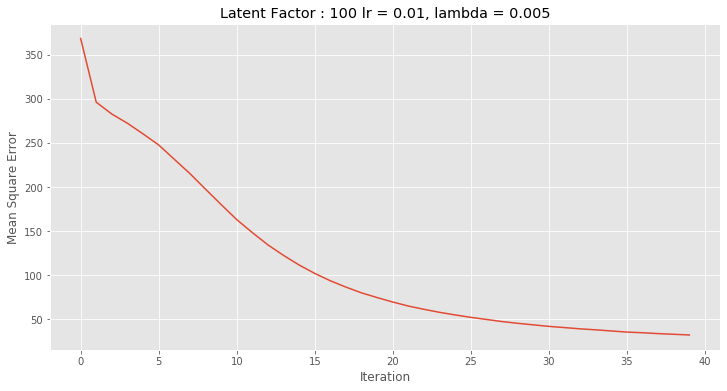

Latent factor :  200
Iteration: 10 ; error = 188.7343
Iteration: 20 ; error = 63.9673
Iteration: 30 ; error = 28.6437
Iteration: 40 ; error = 18.3460
Test Error :  9507.807376769108


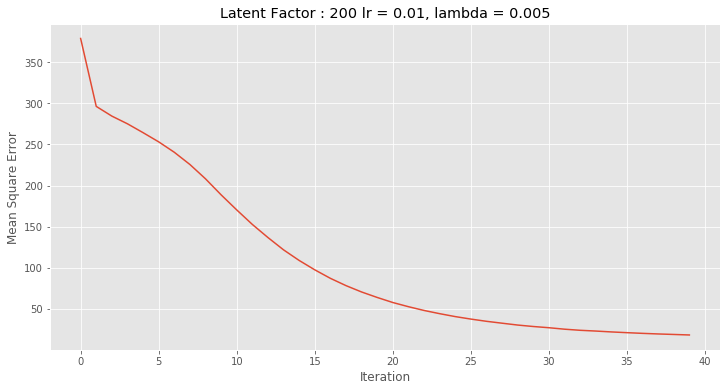

In [0]:

Z = np.max(train_data,axis = 0)
n_users = Z[1]
n_items = Z[0]
print(n_users,n_items)

R = np.zeros((n_users,n_items))

for l in train_data:
    R[l[1]-1,l[0]-1] = l[2]

 

print(R[:5]) 
factors = [10, 20, 40, 80, 100, 200]
for k in factors:
    alpha = 0.01
    beta = 0.005
    lf = Latent_Factor(R, K=k, alpha=alpha, beta=beta, iterations=40)
    X = lf.train()
    test_error = 0.0
    predicted = lf.full_matrix()
    for l in test_data:
        test_error += pow(l[2] - predicted[l[1]-1, l[0]-1], 2)
    print('Test Error : ',test_error)
    X = np.array(X)
    style.use('ggplot')
    plt.figure(figsize=(12,6))
    plt.xlabel("Iteration")
    plt.ylabel("Mean Square Error")
    s = "Latent Factor : "+str(k)+" lr = "+str(alpha) + ", lambda = " + str(beta)
    plt.title(s)
    plt.plot(X[:,0],X[:,1])
    plt.show()


    


In [0]:
def user_user_collaborative_filtering(P_inv,R):
    recommendation_matrix = np.dot(P_inv,np.dot(R,np.dot(R.T,np.dot(P_inv,R))))

    return recommendation_matrix

def item_item_collaborative_filtering(Q_inv,R):
    recommendation_matrix = np.dot(R,np.dot(Q_inv,np.dot(R.T,np.dot(R,Q_inv))))

    return recommendation_matrix


In [0]:
import numpy as np
import pandas as pd
from scipy.linalg import fractional_matrix_power

path = '/content/recolab-data/collaborative/'

with open(path+'items.txt') as f:
    items = f.read()
    items = items.split('\n')
    # print(items)
items = items[:-1]
items = np.array(items)
items = np.reshape(items,(items.shape[0],1))

R = []

with open(path+'ratings.txt') as f:
    ratings = f.read().split('\n')
    for row in ratings[:-1]:
        row = row.rstrip().split(" ")
        row = [int(x) for x in row]
        
        R.append(row)

ratings = np.array(R)


print(items.shape)
print(ratings.shape)

row_sum = np.reshape(np.sum(ratings,axis = 1),(ratings.shape[0],1))
col_sum = np.reshape(np.sum(ratings,axis = 0),(ratings.shape[1],1))

P = np.zeros((ratings.shape[0],ratings.shape[0]),dtype = 'int32')
Q = np.zeros((ratings.shape[1],ratings.shape[1]),dtype = 'int32')

for i in range(ratings.shape[0]):
    P[i][i] = int(row_sum[i][0])

for i in range(ratings.shape[1]):
    Q[i][i] = int(col_sum[i][0])

print(P[:5])
print(Q[:5])

P_inv = np.zeros((P.shape[0],P.shape[1]))
Q_inv = np.zeros((Q.shape[0],Q.shape[1]))
for i in range(P.shape[0]):
    if P[i,i] == 0:
        P_inv[i,i] = 0
    else:
        P_inv[i,i] = 1/P[i,i]

for i in range(Q.shape[0]):
    if Q[i,i] == 0:
        Q_inv[i,i] = 0
    else:
        Q_inv[i,i] = 1/Q[i,i]

P_inv = P_inv ** (0.5)
Q_inv = Q_inv ** (0.5)
print(P_inv[:5])
print(Q_inv[:5])




(563, 1)
(9985, 563)
[[35  0  0 ...  0  0  0]
 [ 0 26  0 ...  0  0  0]
 [ 0  0 44 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
[[1089    0    0 ...    0    0    0]
 [   0 3350    0 ...    0    0    0]
 [   0    0 3187 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]
[[0.16903085 0.         0.         ... 0.         0.         0.        ]
 [0.         0.19611614 0.         ... 0.         0.         0.        ]
 [0.         0.         0.15075567 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0.03030303 0.         0.         ... 0.         0.         0.        ]
 [0.         0.01727737 0.         ... 0.         0.         0.        ]
 [0.         0.         0.01771369 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.     

In [0]:
user_recommendation = user_user_collaborative_filtering(P_inv,ratings)

print(user_recommendation[:5])

[[2.38694740e+02 6.23151008e+02 5.71703488e+02 ... 4.83274279e+01
  4.21198998e+01 1.13858692e+00]
 [1.33694107e+02 4.19077188e+02 4.02414436e+02 ... 4.54437612e+01
  3.30921828e+01 8.77272416e-01]
 [2.11111685e+02 7.62741976e+02 6.67605242e+02 ... 6.40146288e+01
  6.02625946e+01 1.19935843e+00]
 [4.22181964e+01 1.31457025e+02 1.33120661e+02 ... 3.29211531e+01
  1.19724823e+01 8.37126661e-02]
 [1.87565757e+02 5.29868278e+02 3.77627664e+02 ... 4.14375013e+01
  3.07946726e+01 1.30077733e+00]]


In [0]:
import heapq
user_500 = user_recommendation[499,:]
top_100 = heapq.nlargest(100,range(len(user_500)),user_500.take)
# print(top_100)
print('\n\nTop 100 recommendations : \n')
for x in top_100:
    print(items[x])

print('\n\nTop 5 recommendations : \n')
top_5 = heapq.nlargest(5,range(len(user_500)),user_500.take)
for x in top_5:
    print(items[x])





Top 100 recommendations : 

['"FOX 28 News at 10pm"']
['"10TV News HD at 11pm"']
['"Family Guy"']
['"10TV Eyewitness News at 5:00"']
['"10TV Eyewitness News at 6:00"']
['"2009 NCAA Basketball Tournament"']
['"NBC 4 at Eleven"']
['"Two and a Half Men"']
['"Seinfeld"']
['"Today"']
['"Access Hollywood"']
['"Everybody Loves Raymond"']
['"Law & Order: Special Victims Unit"']
['"NBC 4 at Six "']
['"NBC 4 Today "']
['"Late Show with David Letterman"']
['"Law & Order"']
['"ABC6 News at 11"']
['"American Idol"']
['"Jeopardy!"']
['"CBS Evening News"']
['"CSI: NY"']
['"That \'70s Show"']
['"SpongeBob SquarePants"']
['"SportsCenter"']
['"Extra"']
['"NCIS"']
['"The Tonight Show with Jay Leno"']
['"2009 NBA Playoffs"']
['"Wheel of Fortune"']
['"Dateline NBC"']
['"ABC6 News at 6"']
['"College Basketball"']
['"The Early Show"']
['"The Oprah Winfrey Show"']
['"NBC Nightly News"']
['"Dancing with the Stars"']
['"CSI: Miami"']
['"Law & Order: Criminal Intent"']
['"Sex and the City"']
['"PGA Tournament"

In [0]:

with open(path+'orig.txt') as f:
    original = f.read().split(' ')
    original = [int(x) for x in original]

# print(original)

count = 0
total_count = sum(original)
for x in top_100:
    if(original[x] == 1):
        count += 1

print(count,total_count)
print(count)

count = 0
for x in top_5:
    if(original[x] == 1):
        count += 1

print(count)




37 117
0.3162393162393162
4


In [0]:
item_recommendation = item_item_collaborative_filtering(Q_inv,ratings)

print(item_recommendation[:5])

[[ 9.60753925 13.10317571 12.23318216 ...  3.21104654  3.1958345
   0.5460337 ]
 [ 4.36209878  7.69620486  7.48711214 ...  2.5659889   2.16145674
   0.35271962]
 [ 8.38784944 16.61201283 14.99775822 ...  4.48553862  4.63638336
   0.57006572]
 [ 1.7660981   3.08458453  3.18108074 ...  2.53653374  0.96078488
   0.04172751]
 [ 5.60925507  8.09948846  6.33780156 ...  2.17182989  1.77302419
   0.44285606]]


In [0]:
import heapq
user_500 = item_recommendation[499,:]
top_100 = heapq.nlargest(100,range(len(user_500)),user_500.take)
# print(top_100)
print('\n\nTop 100 recommendations : \n')
for x in top_100:
    print(items[x])

print('\n\nTop 5 recommendations : \n')
top_5 = heapq.nlargest(5,range(len(user_500)),user_500.take)
for x in top_5:
    print(items[x])



Top 100 recommendations : 

['"10TV Eyewitness News at 5:00"']
['"FOX 28 News at 10pm"']
['"10TV Eyewitness News at 6:00"']
['"10TV News HD at 11pm"']
['"Family Guy"']
['"NBC 4 at Eleven"']
['"2009 NCAA Basketball Tournament"']
['"Access Hollywood"']
['"Two and a Half Men"']
['"Today"']
['"Everybody Loves Raymond"']
['"Seinfeld"']
['"Late Show with David Letterman"']
['"Law & Order: Special Victims Unit"']
['"CBS Evening News"']
['"ABC6 News at 11"']
['"Jeopardy!"']
['"NBC 4 at Six "']
['"NBC 4 Today "']
['"The Oprah Winfrey Show"']
['"American Idol"']
['"Law & Order"']
['"CSI: NY"']
['"House Hunters"']
['"Extra"']
['"The Early Show"']
['"Wheel of Fortune"']
['"That \'70s Show"']
['"ABC6 News at 6"']
['"SpongeBob SquarePants"']
['"Dateline NBC"']
['"The Tonight Show with Jay Leno"']
['"NCIS"']
['"Dancing with the Stars"']
['"Dr. Phil"']
['"Designed to Sell"']
['"NBC Nightly News"']
['"Sex and the City"']
['"CSI: Miami"']
['"Law & Order: Criminal Intent"']
['"48 Hours Mystery"']
['"Ju

In [0]:
count = 0
total_count = sum(original)
for x in top_100:
    if(original[x] == 1):
        count += 1


print('Correct predictions in top 100 : ',count)

count = 0
for x in top_5:
    if(original[x] == 1):
        count += 1

print('Correct predictions in top 5 : ',count)

Correct predictions in top 100 :  52
Correct predictions in top 5 :  4
